# <span style="color:purple"><center>Signals Processing</center></span>
___
<img src="https://i.ibb.co/KbZJ2SF/sound-1781569-1280.png">

___
# <span style="color:purple"><center>Abstract</center></span>

Linear transformations and matrices are the two most important concepts in signal processing.

Signal processing involves the analysis and modification of a signal in order to alter its characteristics in some desirable manner. Example of some aims include wanting to decrease noise, or increase performance and efficiency. This field of study involves various mathematical concepts and algorithms and aims to produce a signal that is of different quality to the original.

In this workbook (and the accompanying YouTube video), we present the applications of some of the theory underpinning Signal Processing from a linear algebra perspective. These involves the development of code in the Julia language, some refinement of existing high-level external code to demonstrate specific principles, and well as the use of inbuilt language functions. Considering the diversity of subject matter in the topic, the application has concentrated on two topics in particular:

- Discrete Fourier Transforms (Audio Signals)
- Convolution (Image Signals)

___

# <span style="color:purple"><center>Group</center></span>
### <span style="color:purple"><center>UUID</center></span>
<center>85524afa-66d6-49d1-933c-3eb5263d1d99</center>

### <span style="color:purple"><center>Authors</center></span>
<table>
  <tr>
    <td>Greg Marshall</td>
    <td>31178800</td>
  </tr>
  <tr>
    <td>Lucinda Fry</td>
    <td>45552274</td>
  </tr>
  <tr>
    <td>Shrikant Agrawal</td>
    <td>45623941</td>
  </tr>
  <tr>
    <td>Shravan Shivpuri</td>
    <td>45396290</td>
  </tr>
</table>

___
___
___
___
___

# <span style="color:purple"><center>Discrete Fourier Transform</center></span>
## <span style="color:purple"><center>(Audio Signals)</center></span>

Fourier Transforms are a method of converting waveforms (functions or signals) from an x-domain (usually time) to the frequency domain. This allows any waveform (no matter the complexity) to be represented as the LINEAR COMBINATION of sinusoidal basis functions.

Once the transform has been executed, a variety of applications / functions can be implemented on the frequency domain, such as audio filtering and image enhancements. The final step is to convert the processed signal back into the original x-domain.

Note: Often there are pre/post processing steps involved before and after the transform. 

<img src="https://i.ibb.co/W54xRbS/fourier-process.jpg">

___
# Environment Setup

In [1]:
using Pkg
using Random
#Pkg.add("JuliaAudio")
#Pkg.add("WAV")
using WAV, Plots, DSP, LinearAlgebra, PyCall
IPython = pyimport("IPython");

## Globals

In [2]:
sample_rate = 8000;
global generated_noises = Float64[];

## Required Functions

In [3]:
#Generate a simple sine wave with the given properties
function gen_wave(secs, sample_rate, freq, shift, filename)
    x = [0:(secs*sample_rate)-1;]
    y = sin.((2 * pi * freq * x / sample_rate).+ shift)
    if filename != ""
        wavwrite(y, "$filename.wav", Fs=sample_rate)
    end
    y
end;
#Add random noise(s) to a given wave
function add_noise(given_wave, num_noise, amp_reduction)
    wavelen = length(given_wave)
    shifts = zeros(num_noise) #rand(200:7800, num_noise)
    noises = rand(300:1500, num_noise) #+ rand(num_noise)
    print("Noise Frequencies (Hz): $noises")
    for i in 1:num_noise
        given_wave += gen_wave(round(
                wavelen/sample_rate), sample_rate, noises[i], shifts[i], "")[1:wavelen]./amp_reduction;
    end
    global generated_noises = noises
    given_wave
end;

___
# Example - Simple 440Hz Sine wave
## Create wave

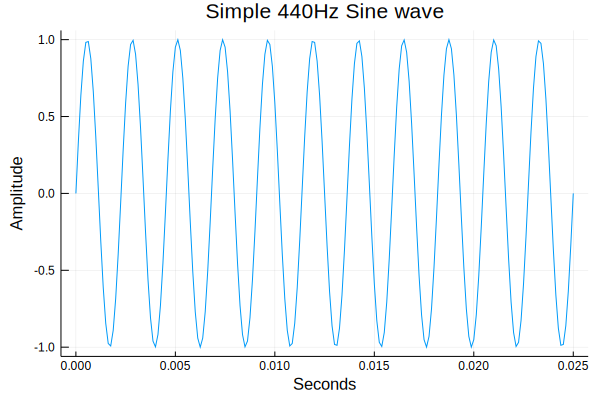

PyObject <IPython.lib.display.Audio object>

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = show(::IOContext{Base.GenericIOBuffer{Array{UInt8,1}}}, ::MIME{Symbol("text/html")}, ::PyObject) at PyCall.jl:895
└ @ PyCall /Users/shravan/.julia/packages/PyCall/ttONZ/src/PyCall.jl:895


In [4]:
simple_wave = Float64[]
simple_wave = gen_wave(1, sample_rate, 440, 0, "")
#Write to file (reduced amplitude)
wavwrite(vcat(simple_wave./10,simple_wave./10, simple_wave./10), "simple.wav", Fs=sample_rate);
tracklen = length(simple_wave)
display(plot([0:200]./sample_rate,simple_wave[1:201],
    legend = false, title="Simple 440Hz Sine wave", yaxis="Amplitude", xaxis="Seconds"))
display(IPython.display.Audio("simple.wav"));

## Pollute wave with noise

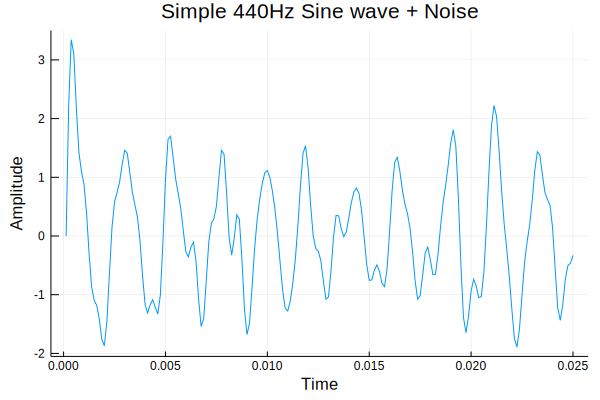

PyObject <IPython.lib.display.Audio object>

Noise Frequencies (Hz): [1208, 404, 434, 636, 866, 623, 813, 405, 536, 1314, 701, 1472, 389, 1441, 1005, 532, 971, 852, 384, 1067]

In [5]:
Random.seed!(12345)
simple_wave_noisy = copy(simple_wave)
#simple_wave_noisy = add_noise(simple_wave_noisy, 2, 1)
simple_wave_noisy = add_noise(simple_wave_noisy, 20, 6)
#Write to file (reduced amplitude)
wavwrite(vcat(simple_wave_noisy./10, simple_wave_noisy./10, simple_wave_noisy./10)
    , "simple_noisy.wav", Fs=sample_rate)
display(plot([1:200]/sample_rate,simple_wave_noisy[1:200],
    legend = false, title="Simple 440Hz Sine wave + Noise", xaxis="Time", yaxis="Amplitude"))
display(IPython.display.Audio("simple_noisy.wav"))

___
# Introducing Discrete Fourier Transform - From First Principles

## Environment - Required Functions

In [6]:
#Generate a Fourier Transform Matrix (F or Ω)
#Sign = +1 for F, -1 for Ω
function get_fourier_transform_matrix(N, given_sign_number)
    actual_sign = sign(given_sign_number) 
    F = zeros(N,N)
    F = complex(F)
    for j = 0:N-1
        for k = 0:N-1
            F[j+1,k+1] = get_ω(j, k, actual_sign)
        end
    end
    F
end;
#Generate ω for an j/k entry in the DFT/Fourier Matrix
function get_ω(j, k, given_sign)
    ℯ^(((given_sign*2π*im)/N)*j*k)
end;

# Demo of $\Omega$ and $F$ - square, symmetric matrices with complex values

In [7]:
N = 10;

## DFT Matrix $\Omega$

$\normalsize\Omega_{N\times N}=\begin{bmatrix}
 1&1&1&1 &1 &\dots & \omega^{(j-1)(k-1)} \\ 
 1& \omega&\omega^2 &\omega^3 &\omega^4 &\dots&\omega^{(j-1)(k-1)} \\ 
 1& \omega^2&  \omega^4&\omega^6  & \omega^8 &\dots &\omega^{(j-1)(k-1)}\\ 
 1& \omega^3& \omega^6 &  \omega^9& \omega^{12} &\dots &\omega^{(j-1)(k-1)}\\ 
 1& \omega^4 &\omega^8  & \omega^{12} &\omega^{16}  &\dots &\omega^{(j-1)(k-1)}\\ 
 \vdots &\vdots &\vdots &\vdots &\vdots &\ddots&\omega^{(j-1)(k-1)}  \\
\omega^{(j-1)(k-1)} & \omega^{(j-1)(k-1)}& \omega^{(j-1)(k-1)} &  \omega^{(j-1)(k-1)} &  \omega^{(j-1)(k-1)}& \omega^{(j-1)(k-1)}& \omega^{(j-1)(k-1)}
\end{bmatrix},\hspace{5mm}\Large \omega_{i,j}=e^{-2\pi ijk/N}$

In [8]:
Ω = get_fourier_transform_matrix(N, -1)

10×10 Array{Complex{Float64},2}:
 1.0-0.0im        1.0-0.0im          …        1.0-0.0im        
 1.0-0.0im   0.809017-0.587785im         0.809017+0.587785im   
 1.0-0.0im   0.309017-0.951057im         0.309017+0.951057im   
 1.0-0.0im  -0.309017-0.951057im        -0.309017+0.951057im   
 1.0-0.0im  -0.809017-0.587785im        -0.809017+0.587785im   
 1.0-0.0im       -1.0-1.22465e-16im  …       -1.0-1.10218e-15im
 1.0-0.0im  -0.809017+0.587785im        -0.809017-0.587785im   
 1.0-0.0im  -0.309017+0.951057im        -0.309017-0.951057im   
 1.0-0.0im   0.309017+0.951057im         0.309017-0.951057im   
 1.0-0.0im   0.809017+0.587785im         0.809017-0.587785im   

## Fourier Matrix $F$

$\normalsize F_{N\times N}=\begin{bmatrix}
 1&1&1&1 &1 &\dots & \omega^{(j-1)(k-1)} \\ 
 1& \omega&\omega^2 &\omega^3 &\omega^4 &\dots&\omega^{(j-1)(k-1)} \\ 
 1& \omega^2&  \omega^4&\omega^6  & \omega^8 &\dots &\omega^{(j-1)(k-1)}\\ 
 1& \omega^3& \omega^6 &  \omega^9& \omega^{12} &\dots &\omega^{(j-1)(k-1)}\\ 
 1& \omega^4 &\omega^8  & \omega^{12} &\omega^{16}  &\dots &\omega^{(j-1)(k-1)}\\ 
 \vdots &\vdots &\vdots &\vdots &\vdots &\ddots&\omega^{(j-1)(k-1)}  \\
\omega^{(j-1)(k-1)} & \omega^{(j-1)(k-1)}& \omega^{(j-1)(k-1)} &  \omega^{(j-1)(k-1)} &  \omega^{(j-1)(k-1)}& \omega^{(j-1)(k-1)}& \omega^{(j-1)(k-1)}
\end{bmatrix},\hspace{5mm}\Large\omega_{i,j}=e^{2\pi ijk/N}$

In [9]:
F = get_fourier_transform_matrix(N, 1)

10×10 Array{Complex{Float64},2}:
 1.0+0.0im        1.0+0.0im          …        1.0+0.0im        
 1.0+0.0im   0.809017+0.587785im         0.809017-0.587785im   
 1.0+0.0im   0.309017+0.951057im         0.309017-0.951057im   
 1.0+0.0im  -0.309017+0.951057im        -0.309017-0.951057im   
 1.0+0.0im  -0.809017+0.587785im        -0.809017-0.587785im   
 1.0+0.0im       -1.0+1.22465e-16im  …       -1.0+1.10218e-15im
 1.0+0.0im  -0.809017-0.587785im        -0.809017+0.587785im   
 1.0+0.0im  -0.309017-0.951057im        -0.309017+0.951057im   
 1.0+0.0im   0.309017-0.951057im         0.309017+0.951057im   
 1.0+0.0im   0.809017-0.587785im         0.809017+0.587785im   

## Important...
## - $\Omega\neq F^{-1}$ - $F$ is not the inverse matrix of $\Omega$...
## - $\Omega \times F = NI$ - However, $F$ IS the Inverse Transform!

In [10]:
n_identity = F*Ω

10×10 Array{Complex{Float64},2}:
         10.0+0.0im          …   4.77396e-15-4.55191e-15im
 -3.33067e-16+0.0im             -2.66454e-15-4.88488e-15im
 -2.22045e-16+2.22045e-16im     -4.84929e-15+2.88363e-15im
 -2.77556e-16+2.22045e-16im      1.30657e-15+3.34204e-15im
          0.0+5.55112e-16im     -1.86819e-16-7.98615e-16im
          0.0+6.12323e-16im  …   -1.5774e-15+3.4989e-15im 
  1.11022e-16+6.66134e-16im      5.48579e-15+3.65758e-15im
  4.10783e-15+1.9984e-15im       8.56874e-15-5.46425e-15im
  1.33227e-15+7.77156e-16im     -1.93557e-15-4.12697e-15im
  4.77396e-15+4.55191e-15im             10.0+0.0im        

## $\dfrac{F\times\Omega}{N}=I$

In [11]:
identity = real.(F*Ω/N)

10×10 Array{Float64,2}:
  1.0          -3.33067e-17  -2.22045e-17  …   1.33227e-16   4.77396e-16
 -3.33067e-17   1.0          -3.15001e-17      7.24971e-17  -2.66454e-16
 -2.22045e-17  -3.15001e-17   1.0              0.0          -4.84929e-16
 -2.77556e-17  -1.10262e-17  -2.34215e-17     -1.89114e-17   1.30657e-16
  0.0          -9.3855e-18   -1.60724e-17     -2.89345e-17  -1.86819e-17
  0.0          -1.98956e-17  -2.22834e-17  …  -3.32277e-17  -1.5774e-16 
  1.11022e-17  -1.1781e-17   -2.40594e-17     -4.51572e-17   5.48579e-16
  4.10783e-16   2.28226e-16  -3.16438e-18      1.65145e-16   8.56874e-16
  1.33227e-16   7.24971e-17   0.0              1.0          -1.93557e-16
  4.77396e-16  -2.66454e-16  -4.84929e-16     -1.93557e-16   1.0        

# Transform simple_wave_noisy with $\Omega$ - The DFT Matrix

## Environment Setup

In [12]:
N = length(simple_wave_noisy)
println("Length of our wave: $N")
F = get_fourier_transform_matrix(N, 1)
Ω = get_fourier_transform_matrix(N, -1);

Length of our wave: 8000


## Transform!

In [13]:
freq_domain = Ω*simple_wave_noisy

8000-element Array{Complex{Float64},1}:
    5.46229728115577e-12 + 0.0im                   
   3.872457909892546e-12 + 4.602988129542851e-12im 
  3.5509373219611007e-12 + 2.6664087604544306e-12im
   3.623767952376511e-12 + 5.279721104756163e-12im 
  -5.401901148616162e-12 + 2.03549677113557e-12im  
  -3.424815986363683e-12 - 3.6042002715674926e-12im
   5.007549930269306e-12 + 1.8174073357357656e-12im
    8.01136934569513e-13 - 2.2845059177711846e-12im
     3.5473846082823e-12 + 2.7939595081960533e-12im
  3.8973269056441495e-12 - 1.6871781749472348e-12im
   -6.31139585038909e-12 + 7.117390010691338e-12im 
   8.677503160470224e-12 + 4.338668313508265e-12im 
 -1.0844658504538529e-11 + 5.234479516502688e-12im 
                         ⋮                         
  1.6612489162071142e-11 + 1.0975165221083216e-11im
   2.162483525580683e-10 - 1.0747314149739395e-10im
   2.481410632526604e-10 + 6.266101526541945e-11im 
   -6.24211793365248e-12 - 5.573300154715355e-11im 
  2.1017854123783763e-11

## Plot the results

### Fourier Transform results in a pair of complex conjugates for each frequency. Visually, this appears as a mirrored plot about the sample rate. E.g. If the DFT for a particular frequency, say 5Hz, is 1+j5, then the DFT for -5Hz is 1-j5.

### This means that the resolution of a Fourier transform is $\dfrac{1}{2}\times sample\_rate$

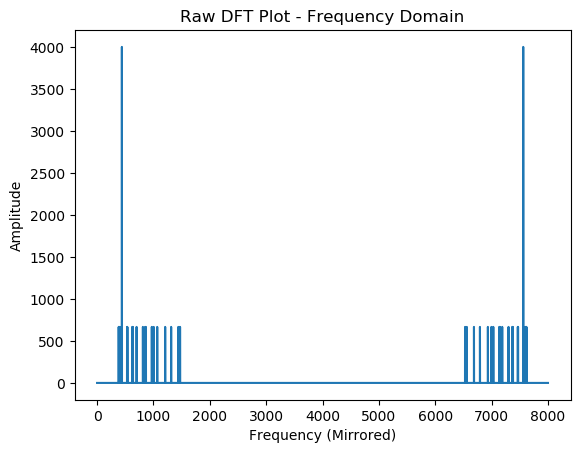

PyObject Text(24.0, 0.5, 'Amplitude')

In [14]:
freq_domain_norms = norm.(freq_domain)
pyplot()
PyPlot.plot(freq_domain_norms);
PyPlot.title("Raw DFT Plot - Frequency Domain");
PyPlot.xlabel("Frequency (Mirrored)")
PyPlot.ylabel("Amplitude")

## Plot cleaned graph, mirror removed and axes relabelled

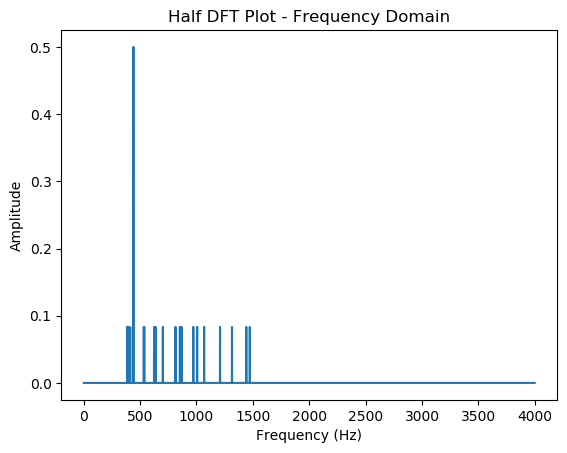

In [15]:
#Remove Conjugate mirror
freq_domain_norms_cleaned = freq_domain_norms[1:Integer(round(length(freq_domain_norms)/2)), :]
#Divide by Sample Rate to get true amplitude
freq_domain_norms_cleaned = freq_domain_norms_cleaned./sample_rate
#Create range labels for X-Axis
x_range = collect(1:length(freq_domain_norms_cleaned))
#Join together
final_dataset = hcat(x_range, freq_domain_norms_cleaned)
#Plot!
PyPlot.plot(final_dataset[:,1], final_dataset[:,2]);
PyPlot.title("Half DFT Plot - Frequency Domain");
PyPlot.xlabel("Frequency (Hz)"); PyPlot.ylabel("Amplitude");

___
# Find original noises in the Frequency Domain data
## We know from before which noise frequencies we injected, can we find these in our frequency domain?

In [16]:
for i = 1:length(generated_noises)
    println("Confirm Noise: ", generated_noises[i], "hz - Amplitude at this freq bin = ", 
        final_dataset[generated_noises[i]+1,2])
end

Confirm Noise: 1208hz - Amplitude at this freq bin = 0.08333333333333248
Confirm Noise: 404hz - Amplitude at this freq bin = 0.08333333333332758
Confirm Noise: 434hz - Amplitude at this freq bin = 0.08333333333333535
Confirm Noise: 636hz - Amplitude at this freq bin = 0.08333333333333368
Confirm Noise: 866hz - Amplitude at this freq bin = 0.08333333333333356
Confirm Noise: 623hz - Amplitude at this freq bin = 0.08333333333333293
Confirm Noise: 813hz - Amplitude at this freq bin = 0.08333333333333229
Confirm Noise: 405hz - Amplitude at this freq bin = 0.08333333333333533
Confirm Noise: 536hz - Amplitude at this freq bin = 0.08333333333333386
Confirm Noise: 1314hz - Amplitude at this freq bin = 0.0833333333333334
Confirm Noise: 701hz - Amplitude at this freq bin = 0.0833333333333333
Confirm Noise: 1472hz - Amplitude at this freq bin = 0.08333333333333344
Confirm Noise: 389hz - Amplitude at this freq bin = 0.08333333333333401
Confirm Noise: 1441hz - Amplitude at this freq bin = 0.08333333

___
# Identify unwanted frequencies directly (No prior knowledge)
## What we really want to do is identify (without knowing beforehand) which noise frequencies exist in the signal!

## <span style="color:green"> 1. Noise Removal (Amplitude High Pass)

### Background noise can sometimes be distinguished by its lower amplitude. We apply this knowledge to our scenario, by removing frequencies which do not meet a set amplitude threshold. The standard threshold for noise is 20% of the signal amplitude. 

In [17]:
freq_domain_copy = copy(freq_domain)
freq_domain_copy_norms = norm.(freq_domain_copy);

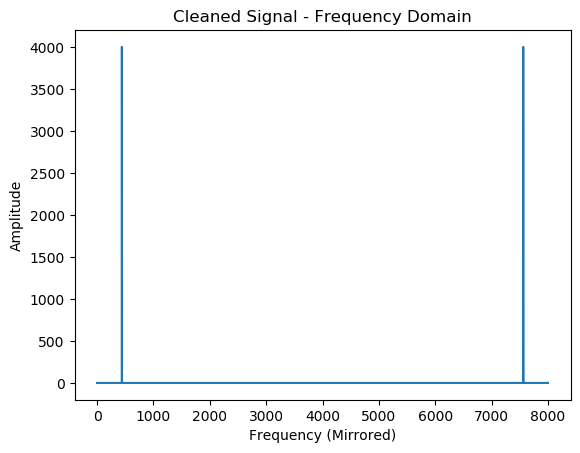

In [18]:
#freq_domain_norms
standard_noise_threshold = 0.2
our_threshold = (sample_rate * 0.5) * standard_noise_threshold
for i = 1:length(freq_domain_copy_norms)
    if freq_domain_copy_norms[i] < our_threshold
        #println("$i: ", freq_domain_copy_norms[i])
        freq_domain_copy[i] = 0
    end
end
PyPlot.plot(norm.(freq_domain_copy))
PyPlot.title("Cleaned Signal - Frequency Domain")
PyPlot.xlabel("Frequency (Mirrored)")
PyPlot.ylabel("Amplitude");

___
# Return back to Time Domain!

## From Earlier: $\dfrac{F\times\Omega}{N}=I$

### $ \overrightarrow{v_{time}}\times \Omega= \overrightarrow{v_{freq}} \hspace{10mm} \therefore \hspace{10mm}\dfrac{\overrightarrow{v_{freq}}\times F}{N} = \overrightarrow{v_{time}} $

In [19]:
cleaned_signal = real.((F*freq_domain_copy)/N)

8000-element Array{Float64,1}:
 -1.4603296349946504e-13
  0.3387379202451581    
  0.6374239897485848    
  0.8607420270038795    
  0.9822872507286731    
  0.9876883405951722    
  0.8763066800439444    
  0.6613118653237705    
  0.3681245526848178    
  0.031410759078272586  
 -0.3090169943748126    
 -0.6129070536528701    
 -0.8443279255019468    
  ⋮                     
  0.8443279255025494    
  0.6129070536524657    
  0.30901699437601704   
 -0.031410759078641784  
 -0.3681245526837194    
 -0.6613118653215504    
 -0.8763066800433064    
 -0.9876883405946872    
 -0.9822872507289477    
 -0.8607420270055302    
 -0.6374239897498241    
 -0.3387379202449199    

## Plot cleaned and recovered 440Hz Sine Wave!

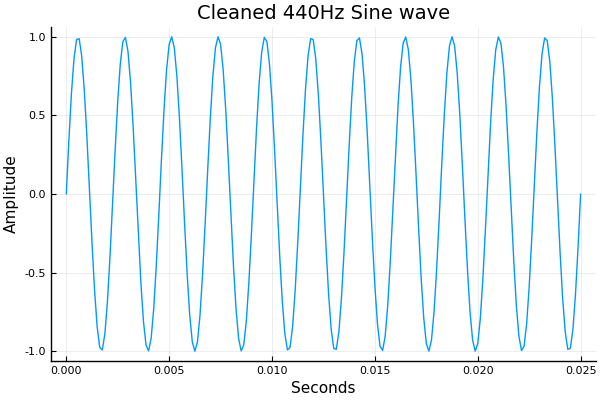

In [20]:
plot([0:200]./sample_rate,cleaned_signal[1:201],
    legend = false, title="Cleaned 440Hz Sine wave", yaxis="Amplitude", xaxis="Seconds")

In [21]:
wavwrite(vcat(cleaned_signal./10, cleaned_signal./10, cleaned_signal./10)
    , "cleaned_wave.wav", Fs=sample_rate)
display(IPython.display.Audio("cleaned_wave.wav"))

PyObject <IPython.lib.display.Audio object>

## <span style="color:green">2. High Pass Filter (Frequency)</span>
### In this example, we filter a waveform based on a threshold/cutoff applied to its constituent frequencies.

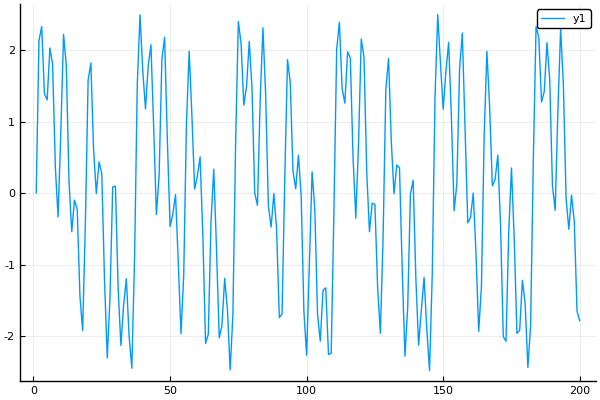

PyObject <IPython.lib.display.Audio object>

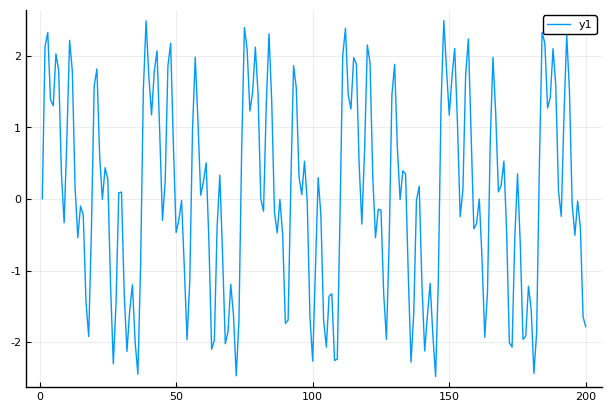

In [22]:
# Here, we add some more clean waves to the 440Hz signal.
#simple_wave = gen_wave(1, sample_rate, 440, 0, "")
simple_wave_chord = copy(simple_wave)
simple_wave_chord += gen_wave(1, sample_rate, 220, 0, "")
simple_wave_chord += gen_wave(1, sample_rate, 880, 0, "")
simple_wave_chord += gen_wave(1, sample_rate, 1760, 0, "")

display(plot(simple_wave_chord[1:200]))

wavwrite(vcat(simple_wave_chord./10, simple_wave_chord./10, simple_wave_chord./10)
    , "simple_wave_chord.wav", Fs=sample_rate)
display(IPython.display.Audio("simple_wave_chord.wav"))

In [23]:
freq_domain_chord = Ω*simple_wave_chord

8000-element Array{Complex{Float64},1}:
  -7.768008458697295e-12 + 0.0im                   
   6.917133532624575e-12 - 2.0255637445121266e-12im
   1.000532989792191e-11 + 2.667518983479056e-13im 
 -3.8475889141409425e-12 + 2.0724845450903473e-11im
 -1.7281287512105337e-11 - 1.0797286675856554e-11im
   3.275602011854062e-12 + 1.2327222576047348e-12im
  -1.355004997094511e-11 - 8.422970654287099e-12im 
   2.446842728431875e-11 - 9.882358820156867e-12im 
 -2.4069635173873394e-13 - 1.751043754438797e-11im 
  1.2957634965005127e-11 + 2.3970894713620794e-11im
 -1.4579448759377556e-11 + 1.526526127726413e-11im 
   8.037126519866433e-12 - 1.8034629345464737e-11im
 -1.1432632618380012e-11 - 2.0308199566443363e-12im
                         ⋮                         
   5.335643038506532e-11 + 9.374179210652756e-11im 
   2.687770006559731e-10 - 1.5060527824850567e-10im
 -1.8256507416936074e-11 + 5.7337745662522366e-11im
  1.2701839580131491e-11 - 6.960197695971004e-11im 
   2.722266856380884e-12

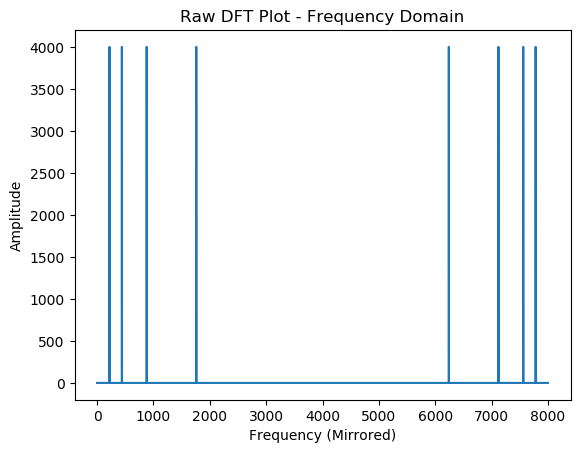

In [24]:
freq_domain_chord_norms = norm.(freq_domain_chord)
pyplot()
PyPlot.plot(freq_domain_chord_norms);
PyPlot.title("Raw DFT Plot - Frequency Domain");
PyPlot.xlabel("Frequency (Mirrored)")
PyPlot.ylabel("Amplitude");

### Implement a HPF (High Pass Filter)

In [25]:
function hpf(freq_domain_vec, cutoff)
    #Make HPF range exclusive of the ends
    cutoff = cutoff - 1
    internal_vec = copy(freq_domain_vec)
    lengthx = length(internal_vec)
    pad_left = zeros((cutoff+1))
    pad_right = zeros(cutoff)
    internal_vec[1:cutoff+1] = pad_left
    internal_vec[lengthx-cutoff+1:1:lengthx] = pad_right
    internal_vec
end

hpf (generic function with 1 method)

### Apply HPF to our frequency domain vector

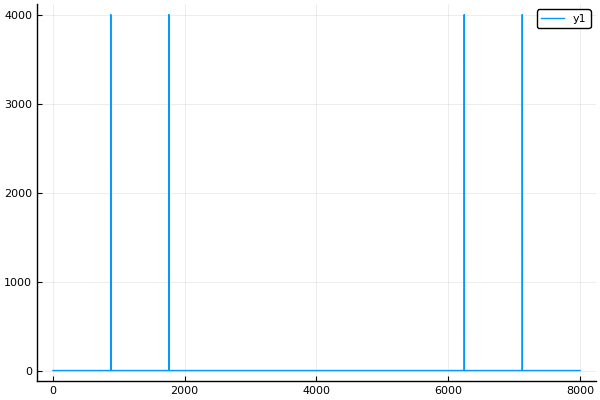

In [26]:
freq_domain_chord_norms_cleaned = hpf(freq_domain_chord_norms, 880)
plot(freq_domain_chord_norms_cleaned)

## Convert back to the Time domain!

In [27]:
cleaned_signal_chord = real.((F*freq_domain_chord_norms_cleaned)/N)

8000-element Array{Float64,1}:
  2.000000000046115  
  0.9578945573522213 
 -0.7423951713128786 
 -1.017580469089369  
 -0.20080785846811075
 -0.142039521917733  
 -0.9616060865410077 
 -0.8432499275629677 
  0.7917591469517142 
  1.9901414297446502 
  1.118033988749596  
 -0.6276167928817242 
 -1.0632032813153187 
  ⋮                  
 -1.0632032813153027 
 -0.6276167928804309 
  1.1180339887495634 
  1.9901414297447308 
  0.7917591469525297 
 -0.8432499275614402 
 -0.9616060865411992 
 -0.14203952191765323
 -0.20080785846897226
 -1.0175804690875982 
 -0.7423951713116432 
  0.9578945573511789 

In [28]:
wavwrite(vcat(cleaned_signal_chord./10, cleaned_signal_chord./10, cleaned_signal_chord./10)
    , "cleaned_signal_chord.wav", Fs=sample_rate)

display(IPython.display.Audio("cleaned_signal_chord.wav"))

PyObject <IPython.lib.display.Audio object>

# Other methods / packages

___
## <span style="color:red"> Julia provides inbuilt functions in the FFTW library to carry out the same operations shown in the code examples above. Like with most in built functions, they are more robust and incorporate many efficiency measures.
</span>   

In [29]:
using FFTW

In [30]:
? fft

search: fft fft! fftfreq fftfilt FFTW fftfilt! fftshift fftintype fftouttype



```
fft(A [, dims])
```

Performs a multidimensional FFT of the array `A`. The optional `dims` argument specifies an iterable subset of dimensions (e.g. an integer, range, tuple, or array) to transform along. Most efficient if the size of `A` along the transformed dimensions is a product of small primes; see `Base.nextprod`. See also [`plan_fft()`](@ref) for even greater efficiency.

A one-dimensional FFT computes the one-dimensional discrete Fourier transform (DFT) as defined by

$$
\operatorname{DFT}(A)[k] =
  \sum_{n=1}^{\operatorname{length}(A)}
  \exp\left(-i\frac{2\pi
  (n-1)(k-1)}{\operatorname{length}(A)} \right) A[n].
$$

A multidimensional FFT simply performs this operation along each transformed dimension of `A`.

!!! note
    This performs a multidimensional FFT by default. FFT libraries in other languages such as Python and Octave perform a one-dimensional FFT along the first non-singleton dimension of the array. This is worth noting while performing comparisons.



In [31]:
? ifft

search: ifft ifft! ifftshift irfft plan_ifft plan_ifft! Cptrdiff_t plan_irfft



```
ifft(A [, dims])
```

Multidimensional inverse FFT.

A one-dimensional inverse FFT computes

$$
\operatorname{IDFT}(A)[k] = \frac{1}{\operatorname{length}(A)}
\sum_{n=1}^{\operatorname{length}(A)} \exp\left(+i\frac{2\pi (n-1)(k-1)}
{\operatorname{length}(A)} \right) A[n].
$$

A multidimensional inverse FFT simply performs this operation along each transformed dimension of `A`.


___
___
___
___
___
# <span style="color:purple"><center>Convolution</center></span>
## <span style="color:purple"><center>(2D Image Signals)</center></span>

Convolution is the operation of two functions to produce a third function, expressing how the shape of one is modified by the other.  The term ‘convolution’ refers to both the result function, as well as the computing process. 

The following Jupyter Notebook code and detail describes some ideas behind the application of Convolution theory to 2D images.

The tasks demonstrated include the following:

- Development of base code (using the concept of a 'Teoplitz Matrix') to carry out convolution of an image.  Application of the code to 'blur' a simple example image

- Use of the inbuilt Julia convolution function to demonstrate that the same outcome is achieved as with the development code

- Application of convolution theory as applied to 2D images to demonstrate other effects including 'Edge Detection, 'Sharpening' and 'Embossing'
___

In [32]:
using Flux.Data.MNIST, PyPlot, LinearAlgebra, Plots, DSP

## Base Convolution Code Development and Application

Loading in MNIST digit database to source an image to use to demonstrate some of the underlying principles of 2D image convolution. 

Displaying an example image (Image #6) to be manipulated.

In [33]:
imgs = MNIST.images();
labels = MNIST.labels();

imgs[6];
Image = vcat(hcat(float.(imgs[6])));
Image_dim = [length(Image[:, 1]), length(Image[1, :])];
display(Gray.(Image))

Creation of a filter matrix that will be used to produce the impact of convolution on a 2D image.  

For this example, a 2 * 2 matrix, containing entries of 0.25, will be used to demonstrate the application of theory for image 'blurring'.  The application of the filter has the impact of averaging the 2 * 2 blocks of 4 adjacent pixels in the image matrix.

In [34]:
Image

28×28 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0       0.0  0.0  0.0
 ⋮            

In [35]:
Filter = [0.25 0.25; 0.25 0.25]
Filter_dim = [length(Filter[:, 1]), length(Filter[1, :])];
Filter

2×2 Array{Float64,2}:
 0.25  0.25
 0.25  0.25

If the matrix size for the input signal is m1 * n1, and the filter matrix size is m2 * n2, the size of the convolution will be: 

\begin{equation*}(m1 + m2 - 1) * (n1 + n2 -1)\end{equation*}

This is the size of full discrete linear convolution.

Next step is creation of a 'zero padded' Filter matrix based on these dimensions to use in the convolution methodology

In [36]:
Padded_Filter = zeros(Image_dim[1]+Filter_dim[1]-1, Image_dim[2]+Filter_dim[2]-1);
Padded_Filter_rows = length(Padded_Filter[:, 1]);
Padded_Filter_columns = length(Padded_Filter[1, :]);

Generation of the 'Padded Filter' matrix (with entries from Filter matrix included in the bottom left corner)

In [37]:
for i in Padded_Filter_rows - Filter_dim[1] + 1: Padded_Filter_rows
    for j in 1 : Filter_dim[2]
        Padded_Filter[i,j] = Filter[i - (Padded_Filter_rows - Filter_dim[1]), j]
    end
end
Padded_Filter

29×29 Array{Float64,2}:
 0.0   0.0   0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.0   0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.0   0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.0   0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.0   0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.0   0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.0   0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.0   0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.0   0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.0   0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.0   0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.0   0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.0   0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 

Coding of 'toeplitz_matrix' function.  

A Toeplitz Matrix is a matrix in which each value along the main diagonal and sub diagonals are constant.  In an N x N matrix, its elements are determined by a (2N - 1) length sequence

\begin{equation*}
{\{t_n  | - (n - 1) \leq N \leq (n - 1)}\}
\end{equation*}

Given a sequence, a Toeplitz matrix can be created by the following steps:

- Placing the sequence in the first column of the matrix

- Shifting it with placing it in the next column.  When shifting, the last element disappears and a new element of the sequence appears.  If there is no new element, zero is including in that location.  

This is be schematically represented as

\begin{equation*}T(m,n) = T_{m-n}\end{equation*}


$$
\begin{bmatrix}
t_{0} & t_{-1} & t_{-2} & .... & .... & .... & .... & t_{-(N-1)}\\
t_{1} & t_{0} & t_{-1} & t_{-2} &  &  &  & \vdots\\
t_{2} & t_{1} & t_{0} & t_{-1} & \ddots &  &  & \vdots\\
\vdots & t_{2} & \ddots & \ddots & \ddots & \ddots &  & \vdots\\
\vdots &  & \ddots & \ddots & \ddots & \ddots & t_{-2} & \vdots\\
\vdots &  &  & \ddots & t_{1} & t_{0} & t_{-1} & t_{-2}\\
\vdots &  &  &  & t_{2} & t_{1} & t_{0} & t_{-1}\\
t_{N-1} & \dots & \dots & \dots & \dots & t_{2} & t_{1} & t_{0}
\end{bmatrix}
$$


For example, the 4 * 4 Toeplitz Matrix for the sequence \begin{equation*} f[n] = [1, 2, 3] \end{equation*} will be

$$
\begin{bmatrix}
1 & 0 & 0 & 0\\
2 & 1 & 0 & 0\\
3 & 2 & 1 & 0\\
0 & 3 & 2 & 1
\end{bmatrix}
$$

The number of columns of a generated Toeplitz matrix should match the number of columns in the Input matrix.


In the following function:
 
- 'n' is the number of columns in the Input matrix, 
  
- 'F' referenced to determine number of rows in the Filter matrix,  

- 'c' references each of the 'Padded Filter' matrix rows (since a Teoplitz Matrix will be created for each row of this matrix)


Its development has been based on a piece of code included in Chapter 7 of ‘Introduction to Applied Linear Algebra, Vectors, Matrices, and Least Squares - Julia Language Companion’ (by Stephen Boyd and Lieven Vandenberghe).

In [38]:
function toeplitz_matrix(n,F,c)
    m = length(F[1, :])
    T = zeros(n+m-1,n)
    for i=1:m
        T[i : n+m : end] .= c[i]
    end
    return T
end

toeplitz_matrix (generic function with 1 method)

The 'toeplitx_matrix' function is used via the following code to create each of the relevant Teoplitz Matrices, and include them in an array for later referencing.  

In [39]:
toeplitz_list = []
c = zeros(length(Padded_Filter[1, :]))
toeplitz_matrix_output = zeros(length(Padded_Filter[1, :]), Image_dim[2])
for i in length(Padded_Filter[:, 1]) : -1 : 1
    c = Padded_Filter[i, : ]
    toeplitz_matrix_output = toeplitz_matrix(Image_dim[2],Filter,c)
    push!(toeplitz_list, toeplitz_matrix_output)
end

Following the creation of each of the relevant Teoplitz Matrices, the next step is creation of what is called a 'Doubly Block Toeplitz Matrix'.

In the matrix A below, all individual components are matrices.  If the structure of A, with respect to these sub-matrices, is Toeplitz, then matrix A is called 'Block Toeplitz'.

$$
\begin{bmatrix}
A_{11} & A_{12} & \dots & A_{1n}\\
A_{21} & A_{22} & \dots & A_{2n}\\
\vdots & \vdots & \vdots & \vdots\\
A_{m1} & A_{m2} & \dots & A_{mn}
\end{bmatrix}
$$

If each individual sub-matrix is also a Toeplitz Matrix, then A is called 'Doubly Blocked Toeplitz'

The number of column blocks in this collated matrix should be the same as the number of rows in the Input matrix.


In the following function:

- 'given_toeplitz_list' is the array of created Toeplitz Matrices 

- 'colsreq' is referenced from the number of rows of the Input matrix

In [40]:
function getdoubly(given_toeplitz_list, colsreq)
    input = given_toeplitz_list
    zerodims = zeros(length(input[1][:,1]), length(input[1][1,:]))
    outputrow = Float64[]
    outputmatrix = Float64[]

    for row = 1:length(input[:,1])
        for col = 1:colsreq
            if col <= row
                if col == 1
                    outputrow = input[row-(col-1)]
                else
                    outputrow = hcat(outputrow, input[row-(col-1)]) 
                end
            else
                outputrow = hcat(outputrow, zerodims)
            end    
        end
        if row == 1
            outputmatrix = outputrow
        else
            outputmatrix = vcat(outputmatrix, outputrow)
        end
    end
outputmatrix
end

getdoubly (generic function with 1 method)

Creation of Doubly Block Toeplitz Matrix, using individual Toeplitz matrices and dimension of Input matrix

In [41]:
getdoubly(toeplitz_list, Image_dim[1])

841×784 Array{Float64,2}:
 0.25  0.0   0.0   0.0   0.0   0.0   …  0.0   0.0   0.0   0.0   0.0   0.0 
 0.25  0.25  0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0 
 0.0   0.25  0.25  0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0 
 0.0   0.0   0.25  0.25  0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0 
 0.0   0.0   0.0   0.25  0.25  0.0      0.0   0.0   0.0   0.0   0.0   0.0 
 0.0   0.0   0.0   0.0   0.25  0.25  …  0.0   0.0   0.0   0.0   0.0   0.0 
 0.0   0.0   0.0   0.0   0.0   0.25     0.0   0.0   0.0   0.0   0.0   0.0 
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0 
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0 
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0 
 0.0   0.0   0.0   0.0   0.0   0.0   …  0.0   0.0   0.0   0.0   0.0   0.0 
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0 
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0 

Conversion of Image matrix into vector for convolution.  Rows of the Input matrix are transposed to a column vector and stacked on top of each other (with last row going first).

In [42]:
Image_vector = []
for i in Image_dim[1] : -1 :  1
    for j in 1 : Image_dim[2]
    push!(Image_vector, Image[i,j])
    end
end

Multiplication of 'Doubly Blocked Toeplitz Matrix' with vectorised input to create vectorised output

In [43]:
Output_vector = [] 
Output_vector = getdoubly(toeplitz_list, Image_dim[1]) * Image_vector;

Conversion of vectorised output to matrix format (Note that matrix output needs to be flipped)

In [44]:
Output_matrix = zeros(Padded_Filter_rows, Padded_Filter_columns)
for i in Padded_Filter_rows : -1 : 1
    for j in 1 : Padded_Filter_columns
    Output_matrix[i,j] = Output_vector[(Padded_Filter_rows - i) * Padded_Filter_columns + j] 
    end
end

Display of convoluted (blurred) image

In [45]:
display(Gray.(Output_matrix))

## Use of Inbuilt Julia 'Convolution' Function

Now the inbuilt Julia function for convolution of a 2D image ('conv2') will be used and a comparison of the output made against that from the developed code

In [46]:
Output_with_ConvFunc = conv2(Image, Filter);
display(Gray.(Output_with_ConvFunc))

┌ Warning: `conv2` is deprecated, use `conv` instead.
│   caller = top-level scope at In[46]:1
└ @ Core In[46]:1


A 'norm' calculation will be used to demonstrate if there is any misalignment in pixel placement following convolution with the use of the developed code vs use of the inbuilt Julia function

In [47]:
misalignment = norm(round.(Output_with_ConvFunc - Output_matrix,digits=6))
println("Measure of misalignment on pixel placement between developed code and inbuilt function = ", misalignment)

Measure of misalignment on pixel placement between developed code and inbuilt function = 0.0


# Other Applications of Convolution to 2D Images

## Loading of Image

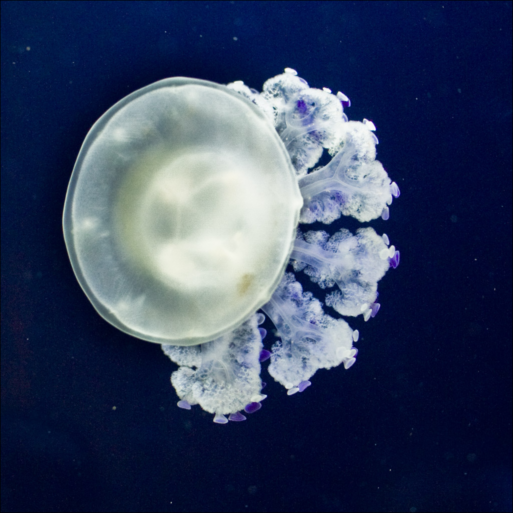

In [48]:
#Pkg.add("Images")
#Pkg.add("ImageMagick")
using Images, ImageMagick
img = load("Jelly1.jpg");
img

## Application of Convolution

This function applies a convolution to a colour image by applying the convolution separately to each of the RGB colour channels then recombines them

In [49]:
function img_conv(image, conv_matrix) 
    # Apply convolution to each of the RGB channels
    conv_r = conv2(red.(image)*1.0, conv_matrix)
    conv_g = conv2(green.(image)*1.0, conv_matrix)
    conv_b = conv2(blue.(image)*1.0, conv_matrix)
    
    # Recombine the RGB channels
    rgb_conv = StackedView(conv_r, conv_g, conv_b)
    
    # Display full image
    println("Convolved Image")
    display(colorview(RGB,rgb_conv))
    
    
    # Display slice of original and convolved images for comparison
    println("Original Image Slice")
    display(colorview(RGB,image[150:300,:]))
    println("Convolved Image Slice")
    display(colorview(RGB,rgb_conv)[150:300,:])
   
end

img_conv (generic function with 1 method)

### Edge Detection

This matrix finds the edges of an image:

$
\begin{bmatrix}
-1 & -1 & -1\\
-1 & 8 & -1\\
-1 &  -1 &  -1
\end{bmatrix}
$

In a smooth area of the image the effect of the convolution is to return  nothing (i.e. 8x - 8x = 0). Edges are accentuated.

┌ Warning: `conv2` is deprecated, use `conv` instead.
│   caller = img_conv(::Array{RGB{Normed{UInt8,8}},2}, ::Array{Float64,2}) at In[49]:3
└ @ Main ./In[49]:3
┌ Warning: `conv2` is deprecated, use `conv` instead.
│   caller = img_conv(::Array{RGB{Normed{UInt8,8}},2}, ::Array{Float64,2}) at In[49]:4
└ @ Main ./In[49]:4
┌ Warning: `conv2` is deprecated, use `conv` instead.
│   caller = img_conv(::Array{RGB{Normed{UInt8,8}},2}, ::Array{Float64,2}) at In[49]:5
└ @ Main ./In[49]:5


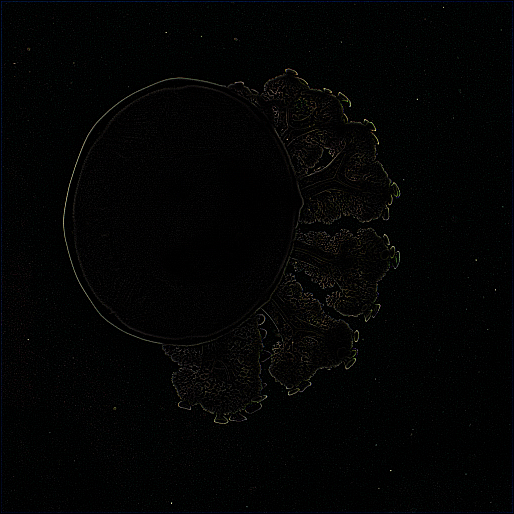

Convolved Image


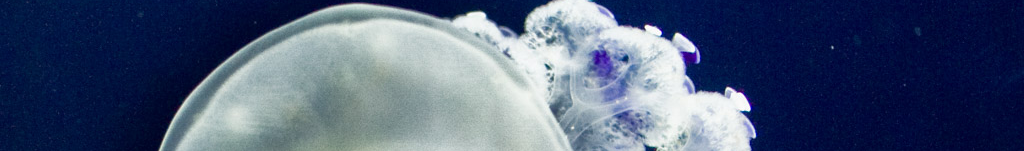

Original Image Slice


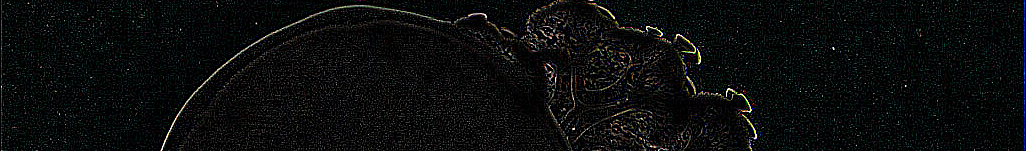

Convolved Image Slice


In [50]:
edge = float.([ -1 -1 -1;
                -1  8 -1;
                -1 -1 -1])

img_conv(img, edge);;

### Sharpening of Image

This matrix sharpens an image:

$
\begin{bmatrix}
-1 & -1 & -1\\
-1 & 9 & -1\\
-1 &  -1 &  -1
\end{bmatrix}
$

In a smooth area of an image the convolution returns the same value (e.g. 5x - 4x = 1x). Where the image is not smooth the differences are accentuated.


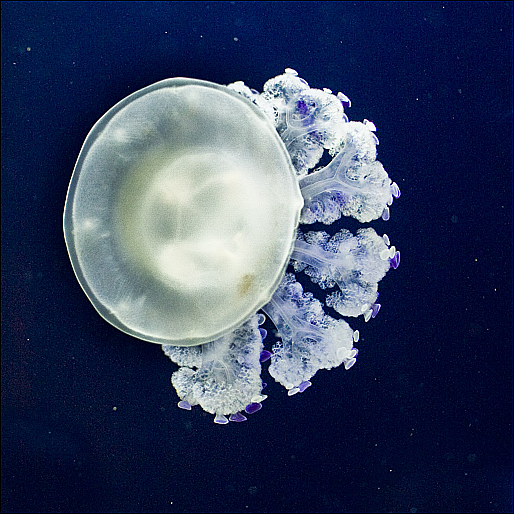

Convolved Image


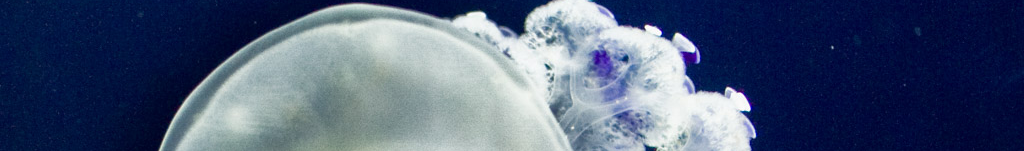

Original Image Slice


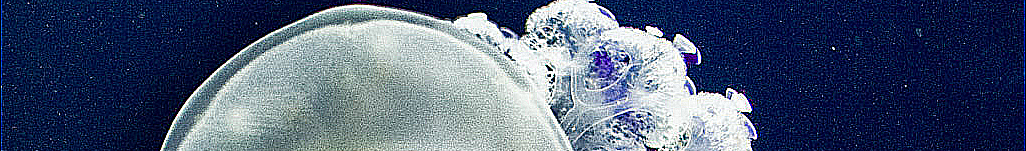

Convolved Image Slice


In [51]:
sharp = float.([ -1 -1  -1;
                -1  9 -1;
                 -1 -1  -1])

img_conv(img, sharp)

### Embossing of  Image

This matrix creates an embossed effect on the image:

$
\begin{bmatrix}
-2 & -1 & 0\\
-1 & 1 & 1\\
0 & 1 &  2
\end{bmatrix}
$

It is similar to sharpning, but in one direction giving the impression of light and shadow

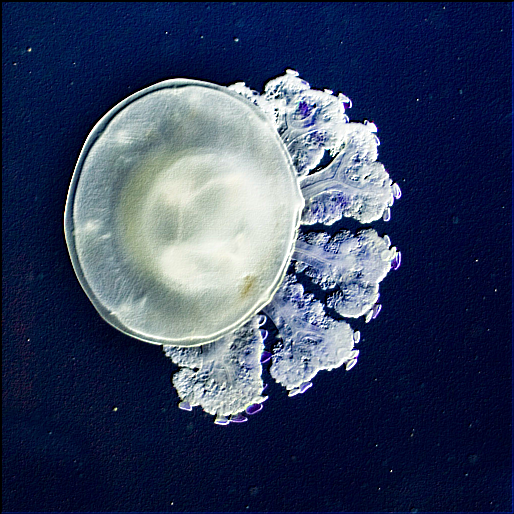

Convolved Image


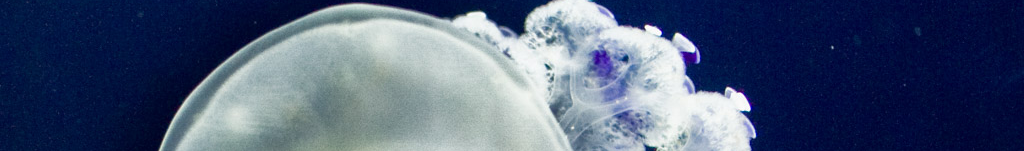

Original Image Slice


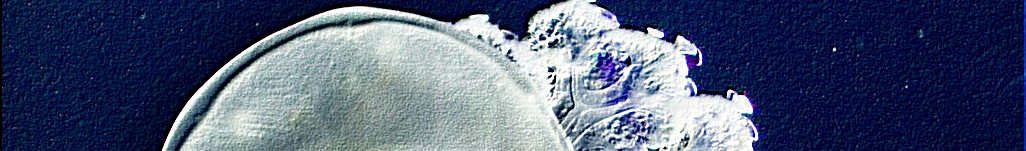

Convolved Image Slice


In [52]:
emboss = float.([ -2 -1  0;
                  -1  1  1;
                   0  1  2])

img_conv(img, emboss)

___
# <span style="color:purple"><center>References</center></span>

In-text: (Coursehero.com, 2019)
Your Bibliography: Coursehero.com. (2019). Complete_DIP.pdf - IV B.Tech I Semester ECE Digital Image Processing ASR INSTITUTE OF TECHNOLOGY PRATHIPADU TADEPALLIGUDEM DEPARTMENT OF ECE DIGITAL. [online] Available at: https://www.coursehero.com/file/40333841/Complete-DIPpdf/ [Accessed 18 Oct. 2019].
 
Linear transformations in signal processing: The geometry of matrices, independent component analysis and data representation
In-text: (Uteng, 2003)
Your Bibliography: Uteng, S. (2003). Linear transformations in signal processing: The geometry of matrices, independent component analysis and data representation. [online] https://www.academia.edu. Available at: https://www.academia.edu/8614677/Linear_transformations_in_signal_processing_The_geometry_of_matrices_independent_component_analysis_and_data_representation [Accessed 18 Oct. 2019].

Boyd, S. and Vandenberghe, L. (2019). Introduction to Applied Linear Algebra (Vectors, Matrices, and Least Squares) - Julia Language Companion. [ebook] Stanford: Stanford University, p.69. Available at: http://vmls-book.stanford.edu/vmls-julia-companion.pdf [Accessed 24 Sep. 2019].
 
Salehi, A. (2018). 2D Convolution as Matrix Multiplication Using Toeplitz Matrices. [ebook] pp.3 - 11. Available at: https://github.com/alisaaalehi/convolution_as_multiplication [Accessed 1 Oct. 2019].
 
Boyd, S. and Vandenberghe, L. (2018). Introduction to Applied Linear (Algebra Vectors, Matrices, and Least Squares). 1st ed. Cambridge: Cambridge University Press, pp.136 - 143.

En.wikipedia.org. (2019). Kernel (image processing). [online] Available at: https://en.wikipedia.org/wiki/Kernel_(image_processing) [Accessed 2 Oct. 2019].
___
___
___
___
___


